In [34]:
import gym_pilleater
import gym
#import gym_sokoban
import matplotlib.pyplot as plt
import thinker
import torch
from thinker import util
import os
from thinker.actor_net import DRCNet
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from gym import spaces
from celluloid import Camera
import pandas as pd
from create_probing_dataset import ProbingDataset
from train_conv_probe import ConvProbe
from thinker.actor_net import DRCNet
import seaborn as sns

In [35]:
data = torch.load("./data/test_data_full_250m.pt")

/tmp/ipykernel_1108/1465330104.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("./data/test_data_full_250m.pt")


In [36]:
cmap = colors.ListedColormap([
    "black", # wall
    "silver", # food
    "red", # g
    "blue", # ge
    "purple", # gee
    "white", # not food
    "red", # g
    "blue", # ge
    "purple", # gee
    "yellow", # pill
    "red", # g 
    "blue", # ge
    "purple", # gee
    "darkgreen", # pillbro
])
bounds = [i+0.5 for i in range(15)]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [50]:
ep_start = 30
ep_len = 6
layer = 1

In [48]:
locprobe = ConvProbe(32, 5, 1, 0)
locprobe.load_state_dict(torch.load(f"./convresults/models/agent_onto_after_16/250m_layer{layer}_kernel1_wd0.001_seed0.pt", map_location=torch.device('cpu')))

/tmp/ipykernel_1108/1230600365.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  locprobe.load_state_dict(torch.load(f"./convresults/models/agent_onto_after_16/250m_layer{

<All keys matched successfully>

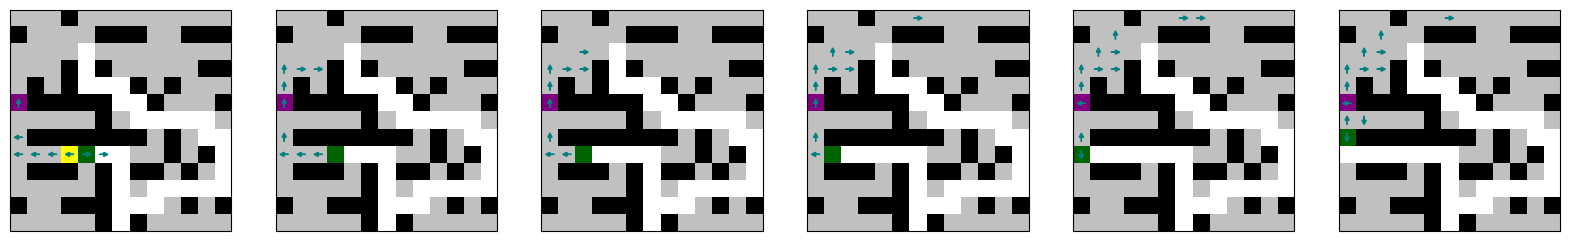

In [51]:
fig, axs = plt.subplots(1,ep_len, figsize=(20,6))


for k in range(ep_len):

    trans = data[ep_start+k]
    state = trans["board_state"]

    
    logitsa, _ = locprobe(trans["hidden_states"][3,(layer*64)+32:(layer*64)+64,:,:])
    arrowsa = []
    for y in range(13):
        for x in range(13):
            action = logitsa.argmax(dim=0)[y,x]
            if action == 1:
                arrowsa.append((x, 12-1*y-0.25, 0, 1)) # up
            elif action == 2:
                arrowsa.append((x, 12-1*y+0.25, 0, -1)) # down
            elif action == 3:
                arrowsa.append((x+0.25, 12-1*y, -1, 0)) # left
            elif action == 4:
                arrowsa.append((x-0.25, 12-1*y, 1, 0)) # right



    mini_board = np.zeros((13, 13))
    for i in range(1, 15):
        mini_board[state[i-1,:, :] == 1] = i
    mini_board = np.flip(mini_board, axis=0)
    axs[k].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[k].set_yticks([])
    axs[k].set_xticks([])
    for (x, y, dx, dy) in arrowsa:
        a1 = axs[k].arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")

plt.show()

In [53]:
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 

env = thinker.make(
            f"gym_pilleater/PillEater-v0", 
            env_n=1, 
            gpu=False,
            wrapper_type=1, 
            has_model=False, 
            train_model=False, 
            parallel=False, 
            save_flags=False,
            mini=True,
            mini_unqtar=False,
            mini_unqbox=False         
        ) 
drc_net = DRCNet(
                obs_space=env.observation_space,
                action_space=env.action_space,
                flags=flags,
                record_state=True,
                input_dim=14
                )
ckp_path = "../../checkpoints/pilleater"
ckp_path = os.path.join(util.full_path(ckp_path), f"ckp_actor_realstep250m.tar")
ckp = torch.load(ckp_path, map_location=torch.device('cpu'))
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

rnn_state = drc_net.initial_state(batch_size=1, device=env.device)
state = env.env.reset(5)
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (14, 13, 13), uint8) and action space Discrete(5)


/tmp/ipykernel_1108/754696585.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(ckp_path, map_location=torch.device('cpu'))


In [64]:
layer = 2
feature = "agent_onto_after_6"
kernel = 1
dim = 5
seed = 12
room_id = 24
think = 1


In [65]:
locprobe = ConvProbe(32,dim, kernel, 1 if kernel==3 else 0)
locprobe.load_state_dict(torch.load(f"./convresults/models/{feature}/250m_layer{layer}_kernel{kernel}_wd0.001_seed0.pt", map_location=torch.device('cpu')))

/tmp/ipykernel_1108/2573061318.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  locprobe.load_state_dict(torch.load(f"./convresults/models/{feature}/250m_layer{layer}_ker

<All keys matched successfully>

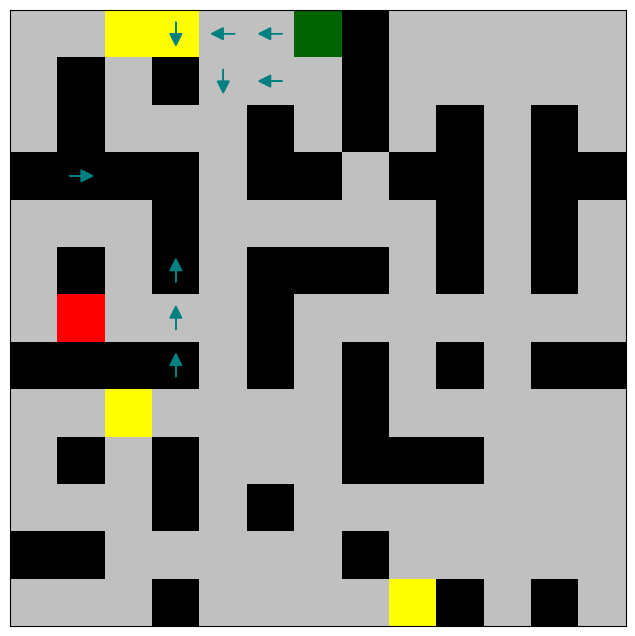

MovieWriter PillowWriter unavailable; using Pillow instead.


In [66]:
fig, axs = plt.subplots(1,1, figsize=(16,8))
camera = Camera(fig)
env = gym.make("gym_pilleater/PillEater-v0")
env.seed(seed)
state = env.reset(room_id=room_id)
state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

rnn_state = drc_net.initial_state(batch_size=1)


cmap = colors.ListedColormap([
    "black", # wall
    "silver", # food
    "red", # g
    "blue", # ge
    "purple", # gee
    "white", # not food
    "red", # g
    "blue", # ge
    "purple", # gee
    "yellow", # pill
    "red", # g 
    "blue", # ge
    "purple", # gee
    "darkgreen", # pillbro
])
bounds = [i+0.5 for i in range(15)]
norm = colors.BoundaryNorm(bounds, cmap.N)

axs.set_xticks([])
axs.set_yticks([])

count = 0
for k in range(50):
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)

    for tick in [1,2,3]:
        logitsa, _ = locprobe(drc_net.hidden_state[0,tick,(layer*64)+32:(layer*64)+64,:,:])
        arrowsa = []
        for y in range(13):
            for x in range(13):
                action = logitsa.argmax(dim=0)[y,x]
                if action == 1:
                    arrowsa.append((x, 12-1*y-0.25, 0, 1)) # up
                elif action == 2:
                    arrowsa.append((x, 12-1*y+0.25, 0, -1)) # down
                elif action == 3:
                    arrowsa.append((x+0.25, 12-1*y, -1, 0)) # left
                elif action == 4:
                    arrowsa.append((x-0.25, 12-1*y, 1, 0)) # right

        mini_board = np.zeros((13, 13))
        for i in range(1, 15):
            mini_board[state["real_states"][0][i-1,:, :] == 1] = i
        mini_board = np.flip(mini_board, axis=0)
        axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
        for (x, y, dx, dy) in arrowsa:
            a1 = axs.arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")
        plt.pause(0.1)
        camera.snap()
    for _ in range(think):
        actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        for tick in [1,2,3]:
            logitsa, _ = locprobe(drc_net.hidden_state[0,tick,(layer*64)+32:(layer*64)+64,:,:])
            arrowsa = []
            for y in range(13):
                for x in range(13):
                    action = logitsa.argmax(dim=0)[y,x]
                    if action == 1:
                        arrowsa.append((x, 12-1*y-0.25, 0, 1)) # up
                    elif action == 2:
                        arrowsa.append((x, 12-1*y+0.25, 0, -1)) # down
                    elif action == 3:
                        arrowsa.append((x+0.25, 12-1*y, -1, 0)) # left
                    elif action == 4:
                        arrowsa.append((x-0.25, 12-1*y, 1, 0)) # right

            mini_board = np.zeros((13, 13))
            for i in range(1, 15):
                mini_board[state["real_states"][0][i-1,:, :] == 1] = i
            mini_board = np.flip(mini_board, axis=0)
            axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
            for (x, y, dx, dy) in arrowsa:
                a1 = axs.arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")
            plt.pause(0.1)
            camera.snap()



    state, reward, done, info = env.step(actor_out.action.item())
    state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
    env_out = util.create_env_out(actor_out.action, state, torch.tensor([reward]), torch.tensor([done]), info, flags)
    if done:
        mini_board = np.zeros((13, 13))
        for i in range(1, 15):
            mini_board[state["real_states"][0][i-1,:, :] == 1] = i
        mini_board = np.flip(mini_board, axis=0)
        axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
        plt.pause(0.1)
        camera.snap()
        count += 1
        rnn_state = drc_net.initial_state(batch_size=1)
        for j in range(5):
            mini_board = np.zeros((13, 13))
            axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
            plt.pause(0.1)
            camera.snap()
        #actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        state = env.reset(room_id=room_id)
        state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
        env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

animation = camera.animate()
animation.save(f'./gifs/{feature}_kernel{kernel}_think{think}.gif', writer='PillowWriter', fps=4) 

In [8]:
layer = 2
layerg = 0
layers = 1
feature = "agent_onto_after_3"
featureg = "spooky_ghost_loc_future_trajectory_3"
features = "nonspooky_ghost_loc_future_trajectory_3"
kernel = 3
kernelg = 3
dim = 2
seed = 9
room_id = 18
think = 0
locprobe = ConvProbe(32,5, kernel, 1 )
locprobe.load_state_dict(torch.load(f"./convresults/models/{feature}/250m_layer{layer}_kernel{kernel}_wd0.001_seed0.pt", map_location=torch.device('cpu')))
locprobeg = ConvProbe(32,2, kernelg, 2)
locprobeg.load_state_dict(torch.load(f"./convresults/models/{featureg}/250m_layer{layerg}_kernel{kernelg}_wd0.001_seed0.pt", map_location=torch.device('cpu')))
locprobes = ConvProbe(32,2, kernelg, 2)
locprobes.load_state_dict(torch.load(f"./convresults/models/{features}/250m_layer{layers}_kernel{kernelg}_wd0.001_seed0.pt", map_location=torch.device('cpu')))

/tmp/ipykernel_1940/905078904.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  locprobe.load_state_dict(torch.load(f"./convresults/models/{feature}/250m_layer{layer}_ker

<All keys matched successfully>

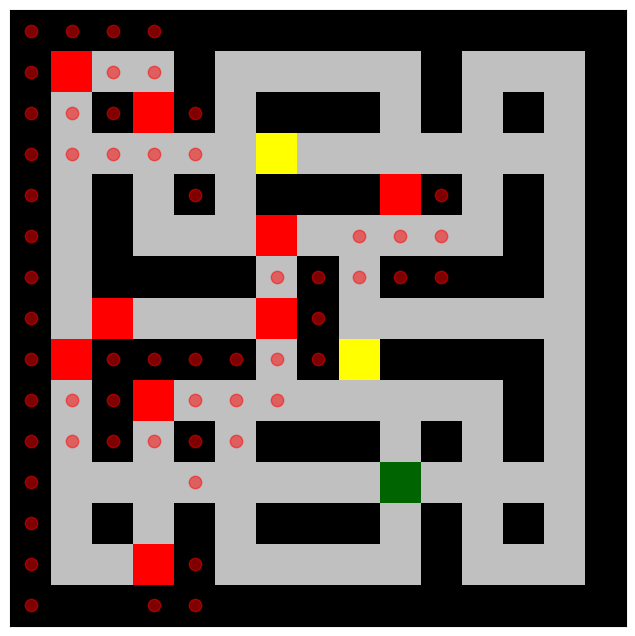

MovieWriter PillowWriter unavailable; using Pillow instead.


In [9]:
fig, axs = plt.subplots(1,1, figsize=(16,8))
camera = Camera(fig)
env = gym.make("gym_pilleater/PillEater-v0")
env.seed(seed)
state = env.reset(room_id=room_id)
state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

rnn_state = drc_net.initial_state(batch_size=1)


cmap = colors.ListedColormap([
    "black", # wall
    "silver", # food
    "red", # g
    "blue", # ge
    "purple", # gee
    "white", # not food
    "red", # g
    "blue", # ge
    "purple", # gee
    "yellow", # pill
    "red", # g 
    "blue", # ge
    "purple", # gee
    "darkgreen", # pillbro
])
bounds = [i+0.5 for i in range(15)]
norm = colors.BoundaryNorm(bounds, cmap.N)

axs.set_xticks([])
axs.set_yticks([])

count = 0
for k in range(40):
    #actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)

    for tick in [1,2,3]:
        logitsa, _ = locprobe(drc_net.hidden_state[0,tick,(layer*64)+32:(layer*64)+64,:,:])
        arrowsa = []
        for y in range(15):
            for x in range(15):
                action = logitsa.argmax(dim=0)[y,x]
                if action == 1:
                    arrowsa.append((x, 14-1*y-0.25, 0, 1)) # up
                elif action == 2:
                    arrowsa.append((x, 14-1*y+0.25, 0, -1)) # down
                elif action == 3:
                    arrowsa.append((x+0.25, 14-1*y, -1, 0)) # left
                elif action == 4:
                    arrowsa.append((x-0.25, 14-1*y, 1, 0)) # right

        logitsa, _ = locprobeg(drc_net.hidden_state[0,tick,(layerg*64)+32:(layerg*64)+64,:,:])
        crossesg = []
        for y in range(15):
            for x in range(15):
                action = logitsa.argmax(dim=0)[y,x]
                if action == 1:
                    crossesg.append((x, 14-1*y)) # up
                elif action == 2:
                    crossesg.append((x, 14-1*y)) # down
                elif action == 3:
                    crossesg.append((x, 14-1*y)) # left
                elif action == 4:
                    crossesg.append((x, 14-1*y)) # right

        mini_board = np.zeros((15, 15))
        for i in range(1, 15):
            mini_board[state["real_states"][0][i-1,:, :] == 1] = i
        mini_board = np.flip(mini_board, axis=0)
        axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
        for (x, y, dx, dy) in arrowsa:
            a1 = axs.arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")
        for (x, y) in crossesg:
            a1 = axs.scatter([x], [y], s=80, color="red", alpha=0.5)
        #for (x, y) in crossesn:
            #a1 = axs.scatter([x], [y], s=80, color="blue", alpha=0.5)
        plt.pause(0.1)
        camera.snap()
    for _ in range(think):
        actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        for tick in [1,2,3]:
            logitsa, _ = locprobe(drc_net.hidden_state[0,tick,(layer*64)+32:(layer*64)+64,:,:])
            arrowsa = []
            for y in range(15):
                for x in range(15):
                    action = logitsa.argmax(dim=0)[y,x]
                    if action == 1:
                        arrowsa.append((x, 14-1*y-0.25, 0, 1)) # up
                    elif action == 2:
                        arrowsa.append((x, 14-1*y+0.25, 0, -1)) # down
                    elif action == 3:
                        arrowsa.append((x+0.25, 14-1*y, -1, 0)) # left
                    elif action == 4:
                        arrowsa.append((x-0.25, 14-1*y, 1, 0)) # right

            mini_board = np.zeros((15, 15))
            for i in range(1, 15):
                mini_board[state["real_states"][0][i-1,:, :] == 1] = i
            mini_board = np.flip(mini_board, axis=0)
            axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
            for (x, y, dx, dy) in arrowsa:
                a1 = axs.arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")
            plt.pause(0.1)
            camera.snap()



    state, reward, done, info = env.step(actor_out.action.item())
    state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
    env_out = util.create_env_out(actor_out.action, state, torch.tensor([reward]), torch.tensor([done]), info, flags)
    if done:
        mini_board = np.zeros((15, 15))
        for i in range(1, 15):
            mini_board[state["real_states"][0][i-1,:, :] == 1] = i
        mini_board = np.flip(mini_board, axis=0)
        axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
        plt.pause(0.1)
        camera.snap()
        count += 1
        rnn_state = drc_net.initial_state(batch_size=1)
        for j in range(5):
            mini_board = np.zeros((15, 15))
            axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
            plt.pause(0.1)
            camera.snap()
        #actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        state = env.reset(room_id=room_id)
        state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
        env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

animation = camera.animate()
animation.save(f'./gifs/{feature}_{featureg}_kerne{kernel}_think{think}.gif', writer='PillowWriter', fps=2) 

In [790]:
ep_len = 6
ep_start = 500

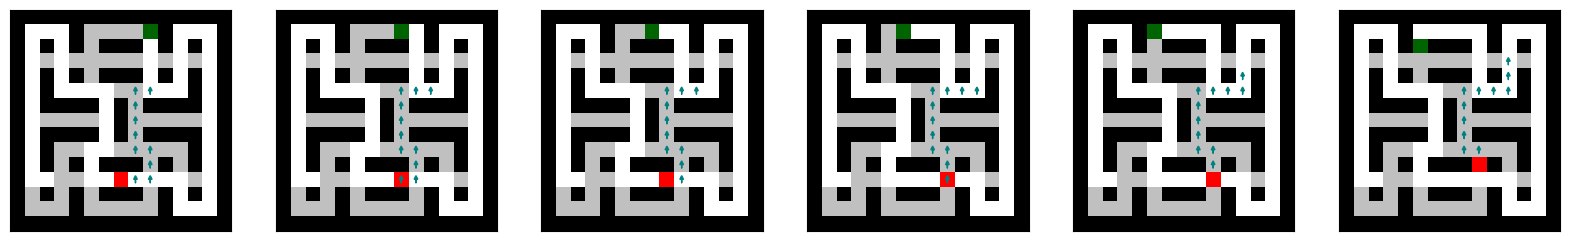

In [791]:
fig, axs = plt.subplots(1,ep_len, figsize=(20,6))


for k in range(ep_len):

    trans = data[ep_start+k]
    state = trans["board_state"]

    
    arrowsa = []
    actions = trans["spooky_ghost_loc_future_trajectory_12"]
    for y in range(0,15):
        for x in range(0,15):
            action = actions[y, x]
            if action == 1:
                arrowsa.append((x, 14-1*y-0.25, 0, 1)) # up
            elif action == 2:
                arrowsa.append((x, 14-1*y+0.25, 0, -1)) # down
            elif action == 3:
                arrowsa.append((x+0.25, 14-1*y, -1, 0)) # left
            elif action == 4:
                arrowsa.append((x-0.25, 14-1*y, 1, 0)) # right



    mini_board = np.zeros((15, 15))
    for i in range(1, 15):
        mini_board[state[i-1,:, :] == 1] = i
    mini_board = np.flip(mini_board, axis=0)
    axs[k].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

    axs[k].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[k].set_yticks([])
    axs[k].set_xticks([])
    for (x, y, dx, dy) in arrowsa:
        a1 = axs[k].arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")

plt.show()

In [3]:
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 

env = thinker.make(
            f"gym_pilleater/PillEater-v0", 
            env_n=1, 
            gpu=False,
            wrapper_type=1, 
            has_model=False, 
            train_model=False, 
            parallel=False, 
            save_flags=False,
            mini=True,
            mini_unqtar=False,
            mini_unqbox=False         
        ) 
drc_net = DRCNet(
                obs_space=env.observation_space,
                action_space=env.action_space,
                flags=flags,
                record_state=True,
                )
ckp_path = "../../drc_pilleater"
ckp_path = os.path.join(util.full_path(ckp_path), f"ckp_actor_realstep50m_v2.tar")
ckp = torch.load(ckp_path, map_location=torch.device('cpu'))
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

rnn_state = drc_net.initial_state(batch_size=1, device=env.device)
state = env.env.reset(5)
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (14, 15, 15), uint8) and action space Discrete(5)
/tmp/ipykernel_34899/1845916711.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues 

In [190]:
id = 24
seed = 5

In [191]:
results = {}
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 

with torch.no_grad():
    for think in [0,2]:
        r = 0
        d = 0
        env = gym.make("gym_pilleater/PillEater-v0")
        env.seed(seed)
        state = env.reset(room_id=id)
        state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
        env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
        rnn_state = drc_net.initial_state(batch_size=1)
        for _ in range(think):
                actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
                env_out = util.create_env_out(torch.tensor([0]), state, torch.tensor([0]), torch.tensor([False]), {}, flags)
        print(f"{think=}")
        while d < 1:
            actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
            state, reward, done, info = env.step(actor_out.action.item())
            r += reward
            state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
            env_out = util.create_env_out(actor_out.action, state, torch.tensor([reward]), torch.tensor([done]), info, flags)
            if done:
                d += 1
                env.seed(d)
                rnn_state = drc_net.initial_state(batch_size=1)
                state = env.reset(room_id=id)
                state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
                env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
                for _ in range(think):
                    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
                    env_out = util.create_env_out(torch.tensor([0]), state, torch.tensor([0]), torch.tensor([False]), {}, flags)
        print(f"{r=}")
        results[think] = r 

think=0
r=9
think=2
r=159


In [49]:
feature = "agent_onto_after_6"
kernel = 3
layer = 2
seed = 5
dim = 5
id = 4
r = 0

In [7]:
locprobe = ConvProbe(32,dim, kernel, 1 if kernel==3 else 0)
locprobe.load_state_dict(torch.load(f"./convresults/models/{feature}/250m_layer{layer}_kernel{kernel}_wd0.001_seed0.pt", map_location=torch.device('cpu')))

/tmp/ipykernel_34899/2573061318.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  locprobe.load_state_dict(torch.load(f"./convresults/models/{feature}/250m_layer{layer}_ke

<All keys matched successfully>

In [13]:
env = gym.make("gym_pilleater/PillEater-v0")
env.seed(seed)
state = env.reset(room_id=id)
state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
rnn_state = drc_net.initial_state(batch_size=1)
steps = []

In [10]:
pause = False

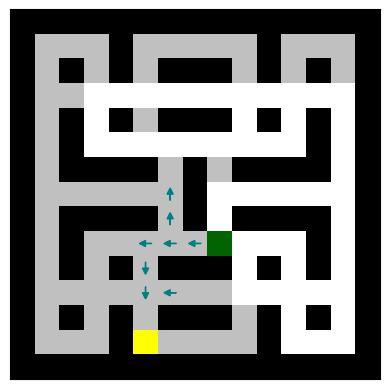

In [311]:
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)

for tick in [1,2,3]:
    logitsa, _ = locprobe(drc_net.hidden_state[0,tick,(layer*64)+32:(layer*64)+64,:,:])
    arrowsa = []
    for y in range(15):
        for x in range(15):
            action = logitsa.argmax(dim=0)[y,x]
            if action == 1:
                arrowsa.append((x, 14-1*y-0.25, 0, 1)) # up
            elif action == 2:
                arrowsa.append((x, 14-1*y+0.25, 0, -1)) # down
            elif action == 3:
                arrowsa.append((x+0.25, 14-1*y, -1, 0)) # left
            elif action == 4:
                arrowsa.append((x-0.25, 14-1*y, 1, 0)) # right


    mini_board = np.zeros((15, 15))
    for i in range(1, 15):
        mini_board[state["real_states"][0][i-1,:, :] == 1] = i
    mini_board = np.flip(mini_board, axis=0)
    steps += [(mini_board, arrowsa)]
plt.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
plt.xticks([])
plt.yticks([])
for (x, y, dx, dy) in arrowsa:
    a1 = plt.arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")
if not pause:
    state, reward, done, info = env.step(actor_out.action.item())
    r += reward
    state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
    env_out = util.create_env_out(actor_out.action, state, torch.tensor([reward]), torch.tensor([done]), info, flags)
    if done:
        state = env.reset(room_id=id)
        state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
        env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

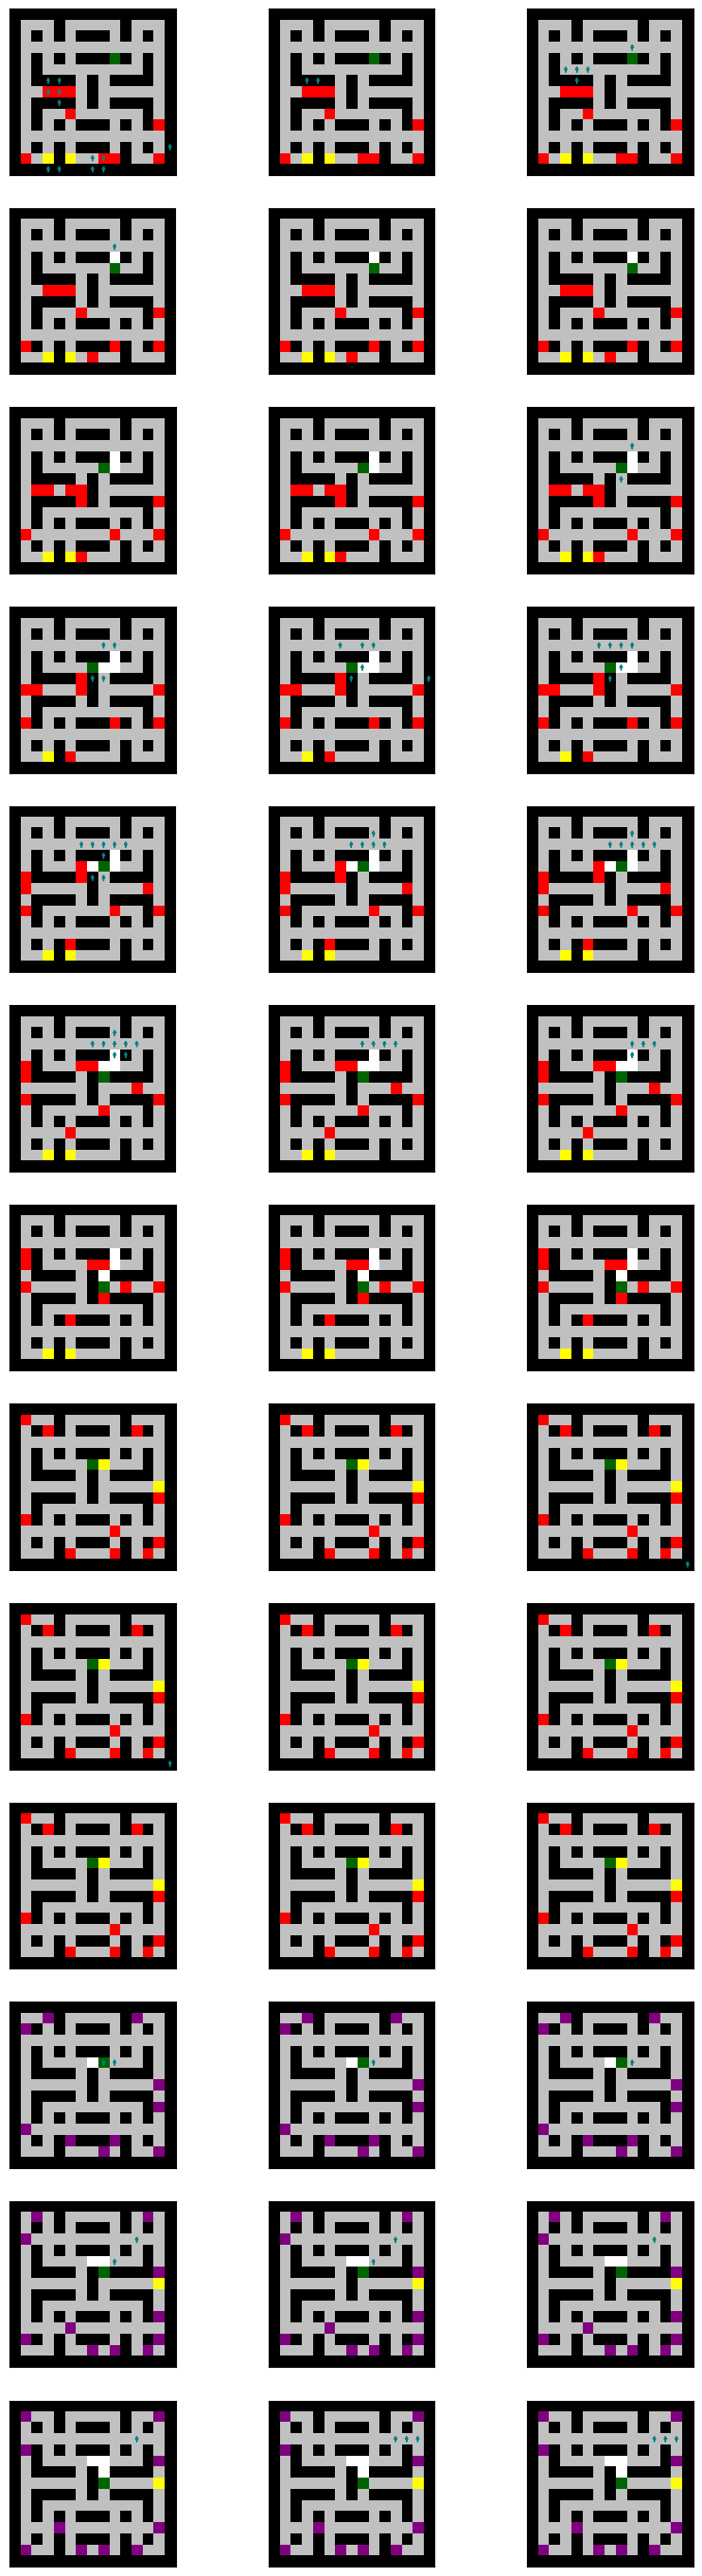

In [409]:
fig, axs = plt.subplots(len(steps)//3, 3, figsize=(10,0.9*len(steps)))

for i, (b, ars) in enumerate(steps):
    axs[i//3][i%3].imshow(b, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[i//3][i%3].set_xticks([])
    axs[i//3][i%3].set_yticks([])
    for (x, y, dx, dy) in ars:
        a1 = axs[i//3][i%3].arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")

In [ ]:
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 

env = thinker.make(
            f"gym_pilleater/PillEater-v0", 
            env_n=1, 
            gpu=False,
            wrapper_type=1, 
            has_model=False, 
            train_model=False, 
            parallel=False, 
            save_flags=False,
            mini=True,
            mini_unqtar=False,
            mini_unqbox=False         
        ) 
drc_net = DRCNet(
                obs_space=env.observation_space,
                action_space=env.action_space,
                flags=flags,
                record_state=True,
                )
ckp_path = "../../drc_pilleater"
ckp_path = os.path.join(util.full_path(ckp_path), f"ckp_actor_realstep250m.tar")
ckp = torch.load(ckp_path, map_location=torch.device('cpu'))
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

rnn_state = drc_net.initial_state(batch_size=1, device=env.device)
state = env.env.reset(5)
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

In [993]:
feature = "agent_onto_after_6"
kernel = 3
layer = 1
seed = 34
dim = 5
id = 3
r = 0
channel = 14

In [994]:
locprobe = ConvProbe(32,dim, kernel, 1 if kernel==3 else 0)
locprobe.load_state_dict(torch.load(f"./convresults/models/{feature}/250m_layer{layer}_kernel{kernel}_wd0.001_seed0.pt", map_location=torch.device('cpu')))

/tmp/ipykernel_115051/2573061318.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  locprobe.load_state_dict(torch.load(f"./convresults/models/{feature}/250m_layer{layer}_k

<All keys matched successfully>

<Axes: >

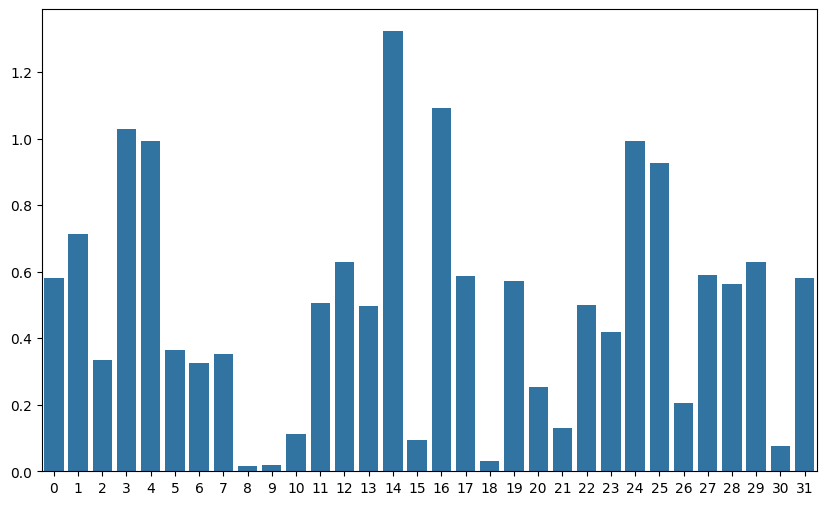

In [991]:
fig, axs = plt.subplots(figsize=(10,6))
sns.barplot(locprobe.conv.weight[4].abs().mean(dim=[1,2]).tolist())

In [1108]:
env = gym.make("gym_pilleater/PillEater-v0")
env.seed(seed)
state = env.reset(room_id=id)
state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
rnn_state = drc_net.initial_state(batch_size=1)
steps = []

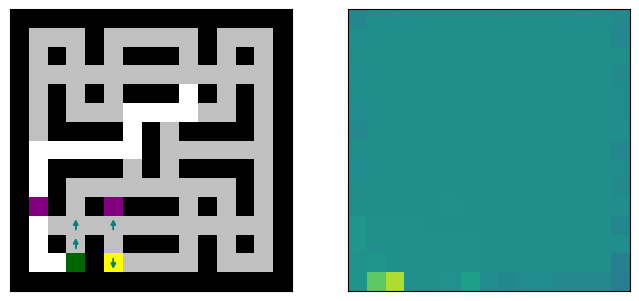

In [1128]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)

for tick in [1,2,3]:
    logitsa, _ = locprobe(drc_net.hidden_state[0,tick,(layer*64)+32:(layer*64)+64,:,:])
    arrowsa = []
    for y in range(15):
        for x in range(15):
            action = logitsa.argmax(dim=0)[y,x]
            if action == 1:
                arrowsa.append((x, 14-1*y-0.25, 0, 1)) # up
            elif action == 2:
                arrowsa.append((x, 14-1*y+0.25, 0, -1)) # down
            elif action == 3:
                arrowsa.append((x+0.25, 14-1*y, -1, 0)) # left
            elif action == 4:
                arrowsa.append((x-0.25, 14-1*y, 1, 0)) # right


    mini_board = np.zeros((15, 15))
    for i in range(1, 15):
        mini_board[state["real_states"][0][i-1,:, :] == 1] = i
    mini_board = np.flip(mini_board, axis=0)
    steps += [(mini_board, arrowsa)]
axs[0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(drc_net.hidden_state[0,3,(layer*64)+channel,:,:].detach(), vmin=-.5, vmax=.5)
axs[1].set_xticks([])
axs[1].set_yticks([])

for (x, y, dx, dy) in arrowsa:
    a1 = axs[0].arrow(x, y, dx * 0.25, dy * 0.25, head_width=0.25, head_length=0.25, color="teal")
if not pause:
    state, reward, done, info = env.step(actor_out.action.item())
    r += reward
    state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
    env_out = util.create_env_out(actor_out.action, state, torch.tensor([reward]), torch.tensor([done]), info, flags)
    if done:
        state = env.reset(room_id=id)
        state = {"real_states": torch.tensor(state).permute(2,0,1).unsqueeze(0)}
        env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)

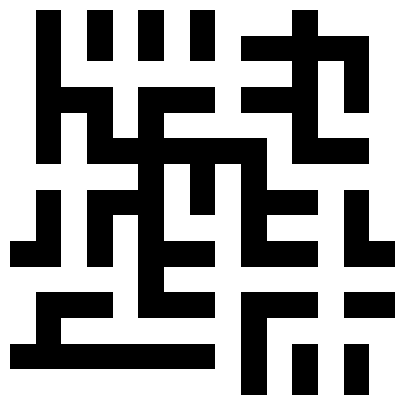

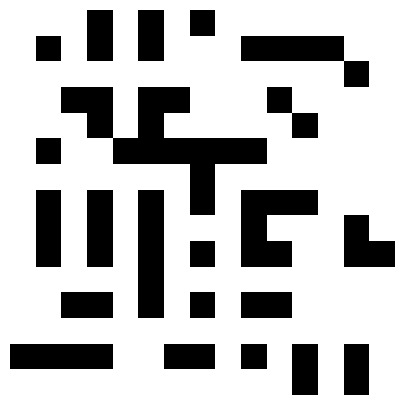

In [379]:
import numpy as np
import random
import matplotlib.pyplot as plt

def initialize_maze(width, height):
    """Initialize the maze grid with all walls"""
    maze = np.ones((height, width), dtype=int)
    return maze

def add_frontier(maze, frontiers, x, y):
    """Add frontier walls of a cell to the list"""
    if x >= 2 and maze[y][x - 2] == 1:
        frontiers.append((x - 2, y, x - 1, y))
    if x < len(maze[0]) - 2 and maze[y][x + 2] == 1:
        frontiers.append((x + 2, y, x + 1, y))
    if y >= 2 and maze[y - 2][x] == 1:
        frontiers.append((x, y - 2, x, y - 1))
    if y < len(maze) - 2 and maze[y + 2][x] == 1:
        frontiers.append((x, y + 2, x, y + 1))

def generate_maze(width, height):
    """Generate maze using Prim's algorithm"""
    maze = initialize_maze(width, height)
    start_x, start_y = random.randrange(0, width, 2), random.randrange(0, height, 2)
    maze[start_y][start_x] = 0
    
    frontiers = []
    add_frontier(maze, frontiers, start_x, start_y)
    
    while frontiers:
        idx = random.randint(0, len(frontiers) - 1)
        x, y, wx, wy = frontiers.pop(idx)
        
        if maze[y][x] == 1:
            maze[y][x] = 0
            maze[wy][wx] = 0
            add_frontier(maze, frontiers, x, y)
    
    return maze

def has_adjacent_empty(maze, x, y):
    """Check if there is an adjacent empty square"""
    adjacent_positions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
    for dx, dy in adjacent_positions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < len(maze[0]) and 0 <= ny < len(maze) and maze[ny][nx] == 0:
            return True
    return False

def remove_random_walls(maze, p=0.3):
    """Remove walls randomly with probability p if adjacent to an empty square, including outer edges"""
    for y in range(len(maze)):
        for x in range(len(maze[0])):
            if maze[y][x] == 1 and has_adjacent_empty(maze, x, y) and random.random() < p:
                maze[y][x] = 0

def plot_maze(maze):
    """Plot the maze using matplotlib"""
    plt.figure(figsize=(5, 5))
    plt.imshow(maze, cmap='binary')
    plt.axis('off')
    plt.show()

# Set maze dimensions
width, height = 15, 15

# Generate the maze
maze = generate_maze(width, height)
plot_maze(maze)

# Randomly remove walls with probability p = 0.3, including edge walls if adjacent to an empty cell
remove_random_walls(maze, p=0.3)

# Plot the final maze
plot_maze(maze)


In [302]:
x, y = 1, 1
maze[y-1:y+1, x-1:x+1].any() == 1

np.True_